In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
#pip install tweepy

In [3]:
#pip install textblob

In [4]:
import tweepy
from tweepy import OAuthHandler 
from textblob import TextBlob

# General Cleaning and Word Cloud Code

We will also be visualizing common words used by Twitter users before, during, and after the Democratic debate about a certain candidate.

**Progress**: Instead of copying and pasting the code, make a defintion and apply that to all of the csvs

In [5]:
#for sentiment analyzing
import nltk
import random
from nltk.classify.scikitlearn import SklearnClassifier
import pickle
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from nltk.classify import ClassifierI
from statistics import mode
from nltk.tokenize import word_tokenize
import re


#for basic preprocessing
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.text import Text
import string, re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/siddhipatel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/siddhipatel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/siddhipatel/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

#### Bloomberg Before the Democratic Debate

In [6]:
bloomberg_0_url = "https://raw.githubusercontent.com/srpatel2000/Elections2020/master/Bloomberg/bloomberg_before_dem_debate.csv"
bloomberg_0_df = pd.read_csv(bloomberg_0_url, error_bad_lines=False)
bloomberg_0_df.head()

,timestamp,Username,Retweets,Text,Mentions,Hashtags
0,Tue Feb 18 15:59:59 +0000 2020,710651691830525953,0,"He wasn’t lyin, you’re mini.pic.twitter.com/xJ...",NaN,NaN
1,Tue Feb 18 15:59:59 +0000 2020,2450994963,0,I’m not saying that I’m saying some of your sm...,NaN,NaN
2,Tue Feb 18 15:59:59 +0000 2020,597232782,0,You fail to realize he's not hurting anyone.,NaN,NaN
3,Tue Feb 18 15:59:59 +0000 2020,20604331,1,But we need moderate Republicans who hate Trum...,@MikeBloomberg,NaN
4,Tue Feb 18 15:59:58 +0000 2020,1385832662,0,That didn't age well.,NaN,NaN


In [7]:
#text preprocessing to prepare for Twitter sentiment analysis

tweets = []
for tweet in np.arange(5000):
    tweets.append(bloomberg_0_df["Text"][tweet])
    
#confirm that not all code is type string
#for text in tweets:
    #print(type(text))
    
#remove punctuation
def remove_punctuation(tweet):
     #to remove links that start with HTTP/HTTPS in the tweet
    tweet = re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)',
                   '', tweet, flags=re.MULTILINE) 
    #to remove other url links
    tweet = re.sub(r'[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)', '', 
                      tweet, flags=re.MULTILINE)
    #remove punctuation
    punctuations = '''!()-[]{};:'"\,<>./?$%^&*_~'''
    tweet = ''.join([i for i in tweet if not i in punctuations])
    return tweet
    
no_punc_tweets = []
for i in tweets:
    if type(i) == str or type(i) == bytes:
        no_punc_tweets.append(remove_punctuation(i))
    else:
        no_punc_tweets.append(i)
                
#tokenize the tweets so we get each word of the tweet   
from nltk.tokenize import RegexpTokenizer
space_tokenizer = RegexpTokenizer("\s+", gaps=True)

space_tokens = []

for text in no_punc_tweets:
    if type(text) == str:
        space_tokens.append(space_tokenizer.tokenize(text))
    else:
        space_tokens.append("NA")
        
#get rid of stop words to improve efficiency
stop_words = list(set(stopwords.words('english')))

def remove_stopwords(sentence):
    return [w for w in sentence if not w in stop_words]

filtered = [remove_stopwords(words) for words in space_tokens]

#add to existing dataframe
bloomberg_0_df["Cleaned Tweets"] = filtered
#bloomberg_0_df = bloomberg_0_df.drop(columns = ["Tokenized Tweets w/o stop words"])
bloomberg_0_df.head()

,timestamp,Username,Retweets,Text,Mentions,Hashtags,Cleaned Tweets
0,Tue Feb 18 15:59:59 +0000 2020,710651691830525953,0,"He wasn’t lyin, you’re mini.pic.twitter.com/xJ...",NaN,NaN,"[He, wasn’t, lyin, you’re, 62gDk]"
1,Tue Feb 18 15:59:59 +0000 2020,2450994963,0,I’m not saying that I’m saying some of your sm...,NaN,NaN,"[I’m, saying, I’m, saying, smears, anti, Semit..."
2,Tue Feb 18 15:59:59 +0000 2020,597232782,0,You fail to realize he's not hurting anyone.,NaN,NaN,"[You, fail, realize, hes, hurting, anyone]"
3,Tue Feb 18 15:59:59 +0000 2020,20604331,1,But we need moderate Republicans who hate Trum...,@MikeBloomberg,NaN,"[But, need, moderate, Republicans, hate, Trump..."
4,Tue Feb 18 15:59:58 +0000 2020,1385832662,0,That didn't age well.,NaN,NaN,"[That, didnt, age, well]"


In [8]:
#takes in a tokenized sentence and then converts each word into Part Of Speech according 
#to their grammatical function
POS = [nltk.pos_tag(tokenized_sent) for tokenized_sent in filtered ]
print(POS[:3])

[[('He', 'PRP'), ('wasn’t', 'VBZ'), ('lyin', 'JJ'), ('you’re', 'RB'), ('62gDk', 'CD')], [('I’m', 'NNP'), ('saying', 'VBG'), ('I’m', 'NNP'), ('saying', 'VBG'), ('smears', 'NNS'), ('anti', 'RB'), ('Semitic', 'NNP'), ('IRONIC', 'NNP'), ('considering', 'VBG'), ('Jewish', 'JJ')], [('You', 'PRP'), ('fail', 'VBP'), ('realize', 'VB'), ('hes', 'NNS'), ('hurting', 'VBG'), ('anyone', 'NN')]]


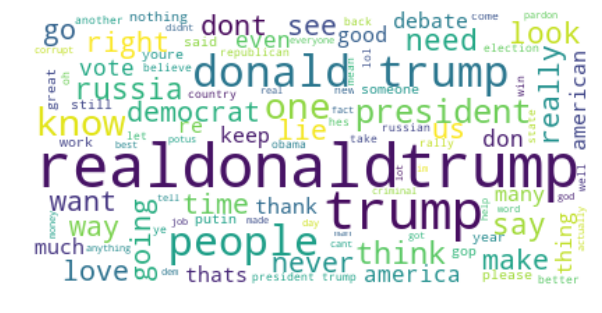

In [52]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#get all the words said by the users
all_words = []
for i in filtered:
    for y in i:
        y = y.lower()
        all_words.append(y)
        
#filter out the words that say bloomberg or anything close to that 
for i in all_words:
    if "bloomberg" in i:
        all_words.pop(all_words.index(i))
        
for i in all_words:
    if "mike" in i:
        all_words.pop(all_words.index(i))
        
all_joined_words =' '.join(all_words)

#Display the generated image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(all_joined_words)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Bloomberg Day of the Democratic Debate

In [10]:
bloomberg_1_url = "https://raw.githubusercontent.com/srpatel2000/Elections2020/master/Bloomberg/bloomberg_day_of_dem_debate.csv"
bloomberg_1_df = pd.read_csv(bloomberg_1_url, error_bad_lines=False)
#bloomberg_1_df.head()

In [11]:
tweets = []
for tweet in np.arange(5000):
    tweets.append(bloomberg_1_df["Text"][tweet])
    
no_punc_tweets = []
for i in tweets:
    if type(i) == str or type(i) == bytes:
        no_punc_tweets.append(remove_punctuation(i))
    else:
        no_punc_tweets.append(i)
                
from nltk.tokenize import RegexpTokenizer
space_tokenizer = RegexpTokenizer("\s+", gaps=True)

space_tokens = []

for text in no_punc_tweets:
    if type(text) == str:
        space_tokens.append(space_tokenizer.tokenize(text))
    else:
        space_tokens.append("NA")

filtered = [remove_stopwords(words) for words in space_tokens]

bloomberg_1_df["Cleaned Tweets"] = filtered
#bloomberg_1_df.head()

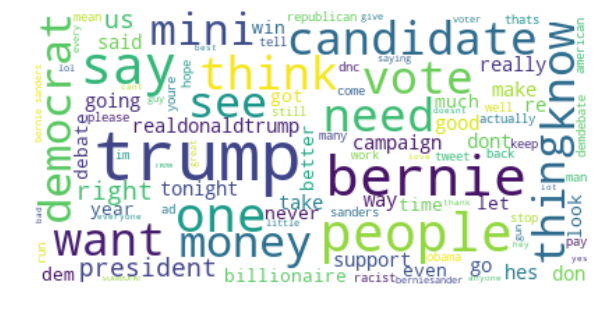

In [12]:
all_words = []
for i in filtered:
    for y in i:
        y = y.lower()
        all_words.append(y)

for i in all_words:
    if "bloomberg" in i:
        all_words.pop(all_words.index(i))
        
for i in all_words:
    if "mike" in i:
        all_words.pop(all_words.index(i))
        
all_joined_words =' '.join(all_words)

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(all_joined_words)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Bloomberg Day After the Democratic Debate

In [13]:
bloomberg_2_url = "https://raw.githubusercontent.com/srpatel2000/Elections2020/master/Bloomberg/bloomberg_after_dem_debate.csv"
bloomberg_2_df = pd.read_csv(bloomberg_2_url, error_bad_lines=False)
#bloomberg_2_df.head()

In [14]:
tweets = []
for tweet in np.arange(5000):
    tweets.append(bloomberg_2_df["Text"][tweet])
    
no_punc_tweets = []
for i in tweets:
    if type(i) == str or type(i) == bytes:
        no_punc_tweets.append(remove_punctuation(i))
    else:
        no_punc_tweets.append(i)
                 
from nltk.tokenize import RegexpTokenizer
space_tokenizer = RegexpTokenizer("\s+", gaps=True)

space_tokens = []

for text in no_punc_tweets:
    if type(text) == str:
        space_tokens.append(space_tokenizer.tokenize(text))
    else:
        space_tokens.append("NA")
    
filtered = [remove_stopwords(words) for words in space_tokens]

bloomberg_2_df["Cleaned Tweets"] = filtered
#bloomberg_2_df.head()

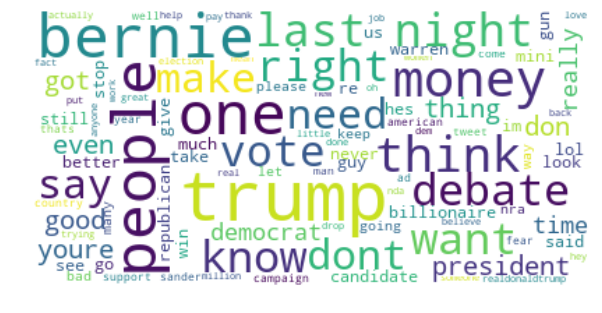

In [15]:
all_words = []
for i in filtered:
    for y in i:
        y = y.lower()
        all_words.append(y)

for i in all_words:
    if "bloomberg" in i:
        all_words.pop(all_words.index(i))
        
for i in all_words:
    if "mike" in i:
        all_words.pop(all_words.index(i))
        
all_joined_words =' '.join(all_words)

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(all_joined_words)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Warren Before the Democratic Debate

In [16]:
warren_0_url = "https://raw.githubusercontent.com/srpatel2000/Elections2020/master/Warren/warren_before_dem_debate.csv"
warren_0_df = pd.read_csv(warren_0_url, error_bad_lines=False)
#warren_0_df.head()

In [17]:
tweets = []
for tweet in np.arange(5000):
    tweets.append(warren_0_df["Text"][tweet])
    
no_punc_tweets = []
for i in tweets:
    if type(i) == str or type(i) == bytes:
        no_punc_tweets.append(remove_punctuation(i))
    else:
        no_punc_tweets.append(i)
                  
from nltk.tokenize import RegexpTokenizer
space_tokenizer = RegexpTokenizer("\s+", gaps=True)

space_tokens = []

for text in no_punc_tweets:
    if type(text) == str:
        space_tokens.append(space_tokenizer.tokenize(text))
    else:
        space_tokens.append("NA")
    

filtered = [remove_stopwords(words) for words in space_tokens]

warren_0_df["Cleaned Tweets"] = filtered
#warren_0_df.head()

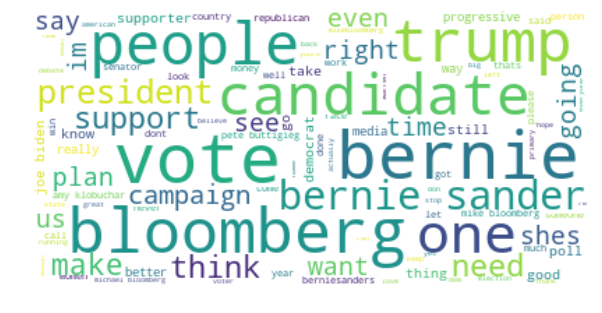

In [18]:
all_words = []
for i in filtered:
    for y in i:
        y = y.lower()
        all_words.append(y)

for i in all_words:
    if "elizabeth" in i:
        all_words.pop(all_words.index(i))
        
for i in all_words:
    if "warren" in i:
        all_words.pop(all_words.index(i))
        
all_joined_words =' '.join(all_words)

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(all_joined_words)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Warren Day of the Democratic Debate

In [19]:
warren_1_url = "https://raw.githubusercontent.com/srpatel2000/Elections2020/master/Warren/warren_day_of_dem_debate.csv"
warren_1_df = pd.read_csv(warren_1_url, error_bad_lines=False)
#warren_1_df.head()

In [20]:
tweets = []
for tweet in np.arange(5000):
    tweets.append(warren_1_df["Text"][tweet])
    
no_punc_tweets = []
for i in tweets:
    if type(i) == str or type(i) == bytes:
        no_punc_tweets.append(remove_punctuation(i))
    else:
        no_punc_tweets.append(i)
                  
from nltk.tokenize import RegexpTokenizer
space_tokenizer = RegexpTokenizer("\s+", gaps=True)

space_tokens = []

for text in no_punc_tweets:
    if type(text) == str:
        space_tokens.append(space_tokenizer.tokenize(text))
    else:
        space_tokens.append("NA")
    

filtered = [remove_stopwords(words) for words in space_tokens]

warren_1_df["Cleaned Tweets"] = filtered
#warren_1_df.head()

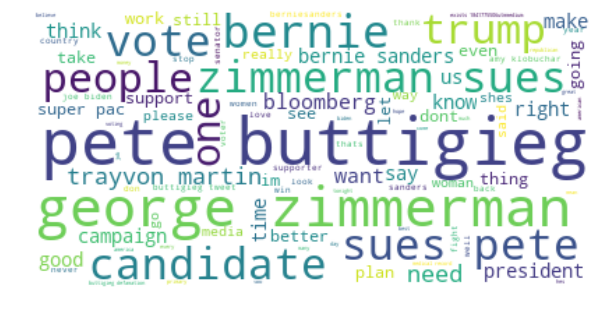

In [21]:
all_words = []
for i in filtered:
    for y in i:
        y = y.lower()
        all_words.append(y)
        
#filter out the words that say warren or anything close to that 
for i in all_words:
    if "elizabeth" in i:
        all_words.pop(all_words.index(i))
        
for i in all_words:
    if "warren" in i:
        all_words.pop(all_words.index(i))
        
all_joined_words =' '.join(all_words)

#Display the generated image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(all_joined_words)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Warren After the Democratic Debate

In [22]:
warren_2_url = "https://raw.githubusercontent.com/srpatel2000/Elections2020/master/Warren/warren_after_dem_debate.csv"
warren_2_df = pd.read_csv(warren_2_url, error_bad_lines=False)
#warren_2_df.head()

In [23]:
tweets = []
for tweet in np.arange(5000):
    tweets.append(warren_2_df["Text"][tweet])
    
no_punc_tweets = []
for i in tweets:
    if type(i) == str or type(i) == bytes:
        no_punc_tweets.append(remove_punctuation(i))
    else:
        no_punc_tweets.append(i)
                  
from nltk.tokenize import RegexpTokenizer
space_tokenizer = RegexpTokenizer("\s+", gaps=True)

space_tokens = []

for text in no_punc_tweets:
    if type(text) == str:
        space_tokens.append(space_tokenizer.tokenize(text))
    else:
        space_tokens.append("NA")
    

filtered = [remove_stopwords(words) for words in space_tokens]

warren_2_df["Cleaned Tweets"] = filtered
#warren_2_df.head()

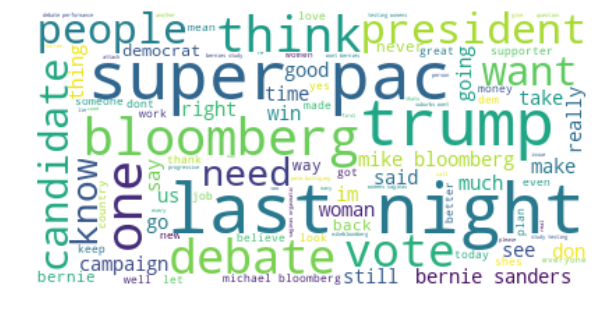

In [24]:
all_words = []
for i in filtered:
    for y in i:
        y = y.lower()
        all_words.append(y)
        
#filter out the words that say warren or anything close to that 
for i in all_words:
    if "elizabeth" in i:
        all_words.pop(all_words.index(i))
        
for i in all_words:
    if "warren" in i:
        all_words.pop(all_words.index(i))
        
all_joined_words =' '.join(all_words)

#Display the generated image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(all_joined_words)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Sanders Before the Democratic Debate

In [25]:
sanders_0_url = "https://raw.githubusercontent.com/srpatel2000/Elections2020/master/Sanders/sanders_before_dem_debate.csv"
sanders_0_df = pd.read_csv(sanders_0_url, error_bad_lines=False)
#sanders_0_df.head()

In [26]:
tweets = []
for tweet in np.arange(5000):
    tweets.append(sanders_0_df["Text"][tweet])
    
no_punc_tweets = []
for i in tweets:
    if type(i) == str or type(i) == bytes:
        no_punc_tweets.append(remove_punctuation(i))
    else:
        no_punc_tweets.append(i)

#tokenize the tweets so we get each word of the tweet 
from nltk.tokenize import RegexpTokenizer
space_tokenizer = RegexpTokenizer("\s+", gaps=True)

space_tokens = []

for text in no_punc_tweets:
    if type(text) == str:
        space_tokens.append(space_tokenizer.tokenize(text))
    else:
        space_tokens.append("NA")
    

filtered = [remove_stopwords(words) for words in space_tokens]

sanders_0_df["Cleaned Tweets"] = filtered
#sanders_0_df.head()

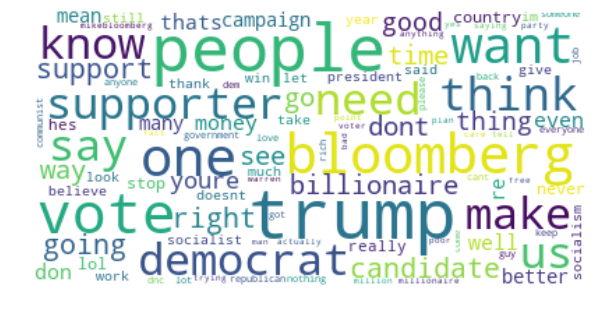

In [27]:
all_words = []
for i in filtered:
    for y in i:
        y = y.lower()
        all_words.append(y)

for i in all_words:
    if "bernie" in i:
        all_words.pop(all_words.index(i))
        
for i in all_words:
    if "sanders" in i:
        all_words.pop(all_words.index(i))
        
all_joined_words =' '.join(all_words)

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(all_joined_words)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Sanders Day of the Democratic Debate

In [28]:
sanders_1_url = "https://raw.githubusercontent.com/srpatel2000/Elections2020/master/Sanders/sanders_day_of_dem_debate.csv"
sanders_1_df = pd.read_csv(sanders_1_url, error_bad_lines=False)
#sanders_1_df.head()

In [29]:
tweets = []
for tweet in np.arange(5000):
    tweets.append(sanders_1_df["Text"][tweet])
    
no_punc_tweets = []
for i in tweets:
    if type(i) == str or type(i) == bytes:
        no_punc_tweets.append(remove_punctuation(i))
    else:
        no_punc_tweets.append(i)

from nltk.tokenize import RegexpTokenizer
space_tokenizer = RegexpTokenizer("\s+", gaps=True)

space_tokens = []

for text in no_punc_tweets:
    if type(text) == str:
        space_tokens.append(space_tokenizer.tokenize(text))
    else:
        space_tokens.append("NA")
    

filtered = [remove_stopwords(words) for words in space_tokens]

sanders_1_df["Cleaned Tweets"] = filtered
#sanders_1_df.head()

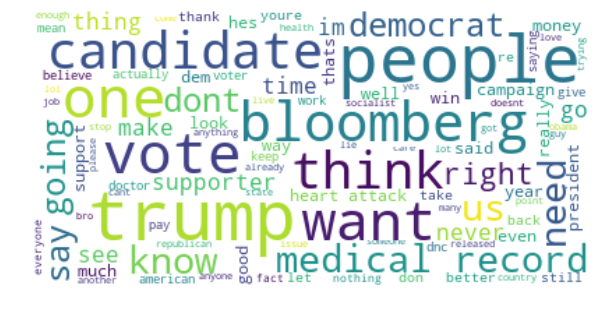

In [30]:
all_words = []
for i in filtered:
    for y in i:
        y = y.lower()
        all_words.append(y)
        
#filter out the words that say sanders or anything close to that 
for i in all_words:
    if "bernie" in i:
        all_words.pop(all_words.index(i))
        
for i in all_words:
    if "sanders" in i:
        all_words.pop(all_words.index(i))
        
all_joined_words =' '.join(all_words)

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(all_joined_words)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Sanders Day of the Democratic Debate

In [31]:
sanders_2_url = "https://raw.githubusercontent.com/srpatel2000/Elections2020/master/Sanders/sanders_after_dem_debate.csv"
sanders_2_df = pd.read_csv(sanders_2_url, error_bad_lines=False)
#sanders_2_df.head()

In [32]:
tweets = []
for tweet in np.arange(5000):
    tweets.append(sanders_2_df["Text"][tweet])
    
no_punc_tweets = []
for i in tweets:
    if type(i) == str or type(i) == bytes:
        no_punc_tweets.append(remove_punctuation(i))
    else:
        no_punc_tweets.append(i)

#tokenize the tweets so we get each word of the tweet 
from nltk.tokenize import RegexpTokenizer
space_tokenizer = RegexpTokenizer("\s+", gaps=True)

space_tokens = []

for text in no_punc_tweets:
    if type(text) == str:
        space_tokens.append(space_tokenizer.tokenize(text))
    else:
        space_tokens.append("NA")
    

filtered = [remove_stopwords(words) for words in space_tokens]

sanders_2_df["Cleaned Tweets"] = filtered
#sanders_2_df.head()

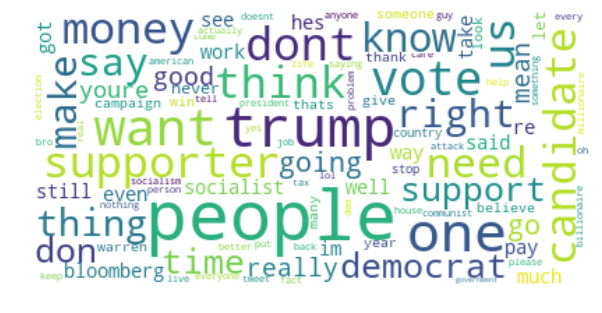

In [33]:
all_words = []
for i in filtered:
    for y in i:
        y = y.lower()
        all_words.append(y)
        
#filter out the words that say sanders or anything close to that 
for i in all_words:
    if "bernie" in i:
        all_words.pop(all_words.index(i))
        
for i in all_words:
    if "sanders" in i:
        all_words.pop(all_words.index(i))
        
all_joined_words =' '.join(all_words)

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(all_joined_words)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Biden Before the Democratic Debate 

In [34]:
biden_0_url = "https://raw.githubusercontent.com/srpatel2000/Elections2020/master/Biden/biden_before_dem_debate.csv"
biden_0_df = pd.read_csv(biden_0_url, error_bad_lines=False)
#biden_0_df.head()

In [35]:
tweets = []
for tweet in np.arange(5000):
    tweets.append(biden_0_df["Text"][tweet])
    
no_punc_tweets = []
for i in tweets:
    if type(i) == str or type(i) == bytes:
        no_punc_tweets.append(remove_punctuation(i))
    else:
        no_punc_tweets.append(i)
                
#tokenize the tweets so we get each word of the tweet   
from nltk.tokenize import RegexpTokenizer
space_tokenizer = RegexpTokenizer("\s+", gaps=True)

space_tokens = []

for text in no_punc_tweets:
    if type(text) == str:
        space_tokens.append(space_tokenizer.tokenize(text))
    else:
        space_tokens.append("NA")
    

filtered = [remove_stopwords(words) for words in space_tokens]

biden_0_df["Cleaned Tweets"] = filtered
#biden_0_df.head()

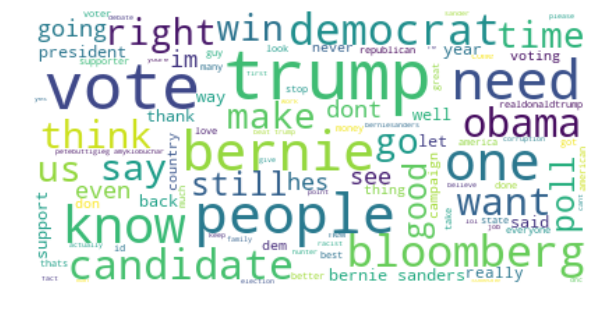

In [36]:
all_words = []
for i in filtered:
    for y in i:
        y = y.lower()
        all_words.append(y)
        
#filter out the words that say sanders or anything close to that 
for i in all_words:
    if "joe" in i:
        all_words.pop(all_words.index(i))
        
for i in all_words:
    if "biden" in i:
        all_words.pop(all_words.index(i))
        
all_joined_words =' '.join(all_words)

#Display the generated image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(all_joined_words)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Biden Day of the Democratic Debate

In [37]:
biden_1_url = "https://raw.githubusercontent.com/srpatel2000/Elections2020/master/Biden/biden_day_of_dem_debate.csv"
biden_1_df = pd.read_csv(biden_1_url, error_bad_lines=False)
#biden_1_df.head()

In [38]:
tweets = []
for tweet in np.arange(5000):
    tweets.append(biden_1_df["Text"][tweet])
    
no_punc_tweets = []
for i in tweets:
    if type(i) == str or type(i) == bytes:
        no_punc_tweets.append(remove_punctuation(i))
    else:
        no_punc_tweets.append(i)
                
#tokenize the tweets so we get each word of the tweet   
from nltk.tokenize import RegexpTokenizer
space_tokenizer = RegexpTokenizer("\s+", gaps=True)

space_tokens = []

for text in no_punc_tweets:
    if type(text) == str:
        space_tokens.append(space_tokenizer.tokenize(text))
    else:
        space_tokens.append("NA")
    

filtered = [remove_stopwords(words) for words in space_tokens]

#add to existing dataframe
biden_1_df["Cleaned Tweets"] = filtered
#biden_1_df.head()

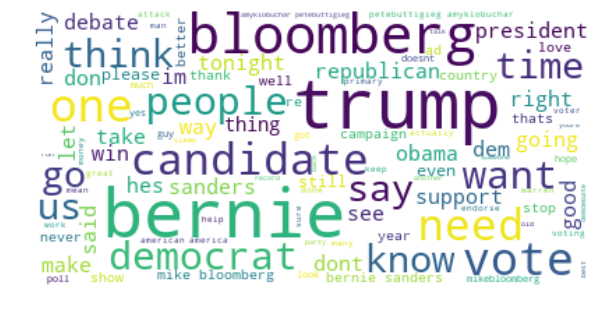

In [39]:
all_words = []
for i in filtered:
    for y in i:
        y = y.lower()
        all_words.append(y)
        
#filter out the words that say sanders or anything close to that 
for i in all_words:
    if "joe" in i:
        all_words.pop(all_words.index(i))
        
for i in all_words:
    if "biden" in i:
        all_words.pop(all_words.index(i))
        
all_joined_words =' '.join(all_words)

#Display the generated image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(all_joined_words)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Biden After the Democratic Debate

In [40]:
biden_2_url = "https://raw.githubusercontent.com/srpatel2000/Elections2020/master/Biden/biden_after_dem_debate.csv"
biden_2_df = pd.read_csv(biden_2_url, error_bad_lines=False)
#biden_2_df.head()

In [41]:
tweets = []
for tweet in np.arange(5000):
    tweets.append(biden_2_df["Text"][tweet])
    
no_punc_tweets = []
for i in tweets:
    if type(i) == str or type(i) == bytes:
        no_punc_tweets.append(remove_punctuation(i))
    else:
        no_punc_tweets.append(i)
                
#tokenize the tweets so we get each word of the tweet   
from nltk.tokenize import RegexpTokenizer
space_tokenizer = RegexpTokenizer("\s+", gaps=True)

space_tokens = []

for text in no_punc_tweets:
    if type(text) == str:
        space_tokens.append(space_tokenizer.tokenize(text))
    else:
        space_tokens.append("NA")
    

filtered = [remove_stopwords(words) for words in space_tokens]

#add to existing dataframe
biden_2_df["Cleaned Tweets"] = filtered
#biden_2_df.head()

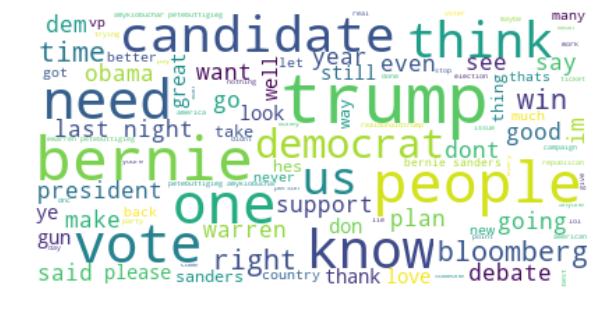

In [42]:
all_words = []
for i in filtered:
    for y in i:
        y = y.lower()
        all_words.append(y)
        
#filter out the words that say sanders or anything close to that 
for i in all_words:
    if "joe" in i:
        all_words.pop(all_words.index(i))
        
for i in all_words:
    if "biden" in i:
        all_words.pop(all_words.index(i))
        
all_joined_words =' '.join(all_words)

#Display the generated image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(all_joined_words)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Trump Before the Democratic Debate

In [43]:
trump_0_url = "https://raw.githubusercontent.com/srpatel2000/Elections2020/master/Trump/trump_before_dem_debate.csv"
trump_0_df = pd.read_csv(trump_0_url, error_bad_lines=False)
#trump_0_df.head()

In [44]:
tweets = []
for tweet in np.arange(5000):
    tweets.append(trump_0_df["Text"][tweet])
    
no_punc_tweets = []
for i in tweets:
    if type(i) == str or type(i) == bytes:
        no_punc_tweets.append(remove_punctuation(i))
    else:
        no_punc_tweets.append(i)
                
#tokenize the tweets so we get each word of the tweet   
from nltk.tokenize import RegexpTokenizer
space_tokenizer = RegexpTokenizer("\s+", gaps=True)

space_tokens = []

for text in no_punc_tweets:
    if type(text) == str:
        space_tokens.append(space_tokenizer.tokenize(text))
    else:
        space_tokens.append("NA")
    

filtered = [remove_stopwords(words) for words in space_tokens]

#add to existing dataframe
trump_0_df["Cleaned Tweets"] = filtered
#trump_0_df.head()

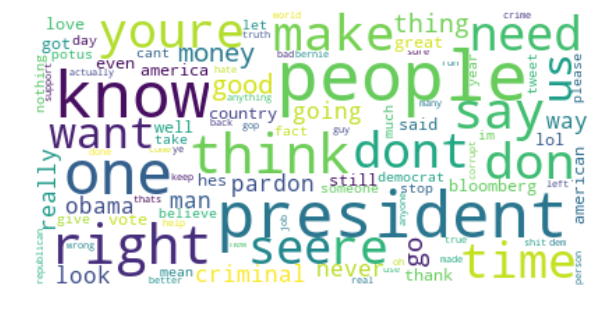

In [45]:
all_words = []
for i in filtered:
    for y in i:
        y = y.lower()
        all_words.append(y)
        
#filter out the words that say trump or anything close to that 
for i in all_words:
    if "trump" in i:
        all_words.pop(all_words.index(i))
        
for i in all_words:
    if "donald" in i:
        all_words.pop(all_words.index(i))
        
all_joined_words =' '.join(all_words)

#Display the generated image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(all_joined_words)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Trump Day of the Democratic Debate

In [46]:
trump_1_url = "https://raw.githubusercontent.com/srpatel2000/Elections2020/master/Trump/trump_day_of_dem_debate.csv"
trump_1_df = pd.read_csv(trump_1_url, error_bad_lines=False)
#trump_1_df.head()

In [47]:
tweets = []
for tweet in np.arange(5000):
    tweets.append(trump_1_df["Text"][tweet])
    
no_punc_tweets = []
for i in tweets:
    if type(i) == str or type(i) == bytes:
        no_punc_tweets.append(remove_punctuation(i))
    else:
        no_punc_tweets.append(i)
                
#tokenize the tweets so we get each word of the tweet   
from nltk.tokenize import RegexpTokenizer
space_tokenizer = RegexpTokenizer("\s+", gaps=True)

space_tokens = []

for text in no_punc_tweets:
    if type(text) == str:
        space_tokens.append(space_tokenizer.tokenize(text))
    else:
        space_tokens.append("NA")
    

filtered = [remove_stopwords(words) for words in space_tokens]

#add to existing dataframe
trump_1_df["Cleaned Tweets"] = filtered
#trump_1_df.head()

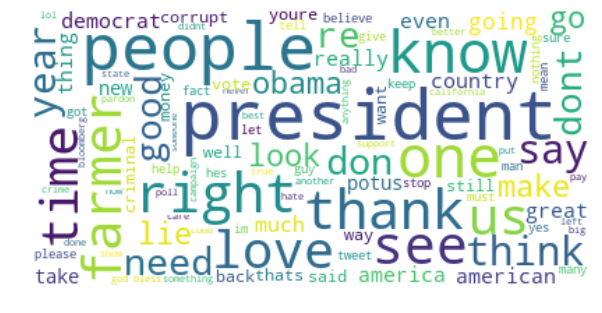

In [48]:
all_words = []
for i in filtered:
    for y in i:
        y = y.lower()
        all_words.append(y)
        
#filter out the words that say trump or anything close to that 
for i in all_words:
    if "trump" in i:
        all_words.pop(all_words.index(i))
        
for i in all_words:
    if "donald" in i:
        all_words.pop(all_words.index(i))
        
all_joined_words =' '.join(all_words)

#Display the generated image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(all_joined_words)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Trump After the Democratic Debate

In [49]:
trump_2_url = "https://raw.githubusercontent.com/srpatel2000/Elections2020/master/Trump/trump_after_dem_debate.csv"
trump_2_df = pd.read_csv(trump_2_url, error_bad_lines=False)
#trump_2_df.head()

In [50]:
tweets = []
for tweet in np.arange(5000):
    tweets.append(trump_2_df["Text"][tweet])
    
no_punc_tweets = []
for i in tweets:
    if type(i) == str or type(i) == bytes:
        no_punc_tweets.append(remove_punctuation(i))
    else:
        no_punc_tweets.append(i)
                
#tokenize the tweets so we get each word of the tweet   
from nltk.tokenize import RegexpTokenizer
space_tokenizer = RegexpTokenizer("\s+", gaps=True)

space_tokens = []

for text in no_punc_tweets:
    if type(text) == str:
        space_tokens.append(space_tokenizer.tokenize(text))
    else:
        space_tokens.append("NA")
    

filtered = [remove_stopwords(words) for words in space_tokens]

#add to existing dataframe
trump_2_df["Cleaned Tweets"] = filtered
#trump_2_df.head()

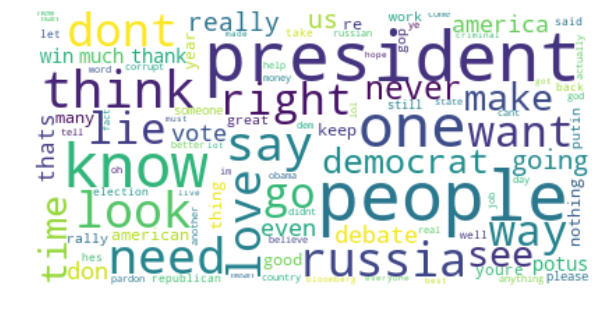

In [51]:
all_words = []
for i in filtered:
    for y in i:
        y = y.lower()
        all_words.append(y)
        
#filter out the words that say trump or anything close to that 
for i in all_words:
    if "trump" in i:
        all_words.pop(all_words.index(i))
        
for i in all_words:
    if "donald" in i:
        all_words.pop(all_words.index(i))
        
all_joined_words =' '.join(all_words)

#Display the generated image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(all_joined_words)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Exporting Cleaned Datasets

In [59]:
#Bloomberg
bloomberg_0_df.to_csv(r'clean_bloomberg_0_df.csv')
bloomberg_1_df
bloomberg_2_df

#Warren
warren_0_df
warren_1_df
warren_2_df

#Sanders
sanders_0_df
sanders_1_df
sanders_2_df

#Biden
biden_0_df
biden_1_df
biden_2_df

#Trump
trump_0_df
trump_1_df
trump_2_df


,timestamp,Username,Retweets,Text,Mentions,Hashtags,Cleaned Tweets
0,Thu Feb 20 15:59:59 +0000 2020,920742760943992832,0,Depressing,NaN,NaN,[Depressing]
1,Thu Feb 20 15:59:59 +0000 2020,3318356398,0,Con man Don did not even write Mein Kampf!,NaN,NaN,"[Con, man, Don, even, write, Mein, Kampf]"
2,Thu Feb 20 15:59:59 +0000 2020,260540412,0,NaN,NaN,NaN,"[N, A]"
3,Thu Feb 20 15:59:59 +0000 2020,28104323,0,Awesome! Congratulations!! You’ve been Q’d!,NaN,NaN,"[Awesome, Congratulations, You’ve, Q’d]"
4,Thu Feb 20 15:59:59 +0000 2020,2209983661,0,Build dams Link rivers Schools Hospitals who h...,@BCCI @MumbaiCricAssoc @PMOIndia @realDonaldTrump,#Lootedpublicbanks,"[Build, dams, Link, rivers, Schools, Hospitals..."
5,Thu Feb 20 15:59:59 +0000 2020,20681995,0,Curious which part of this quote would GOd lik...,NaN,NaN,"[Curious, part, quote, would, GOd, like, best3..."
6,Thu Feb 20 15:59:58 +0000 2020,33706695,0,No you didn’t win every debate.,NaN,NaN,"[No, didn’t, win, every, debate]"
7,Thu Feb 20 15:59:58 +0000 2020,2476855441,0,"If you did not talk smack about your betters, ...",NaN,NaN,"[If, talk, smack, betters, would, anything, say]"
8,Thu Feb 20 15:59:58 +0000 2020,27032599,0,I think it was Personal Assistant to city coun...,NaN,NaN,"[I, think, Personal, Assistant, city, council]"
9,Thu Feb 20 15:59:58 +0000 2020,980569445985935368,2,pic.twitter.com/gBQjWUET6r,NaN,NaN,[6r]
